# Análise de Anomalias em Série Temporal

## Configuração do ambiente de execução

In [96]:
# Garantimos que a versão do statsmodels está fixa com a versão que precisamos
# para a análise.
!pip install statsmodels==0.13.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [97]:
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

In [98]:
print(f'pandas == {pd.__version__}')
print(f'statsmodels == {statsmodels.__version__}')

pandas == 1.3.5
statsmodels == 0.13.2


In [99]:
# habilitamos a visualização especial de dataframes disponível no
# Google Colaboratory, para facilitar a exploração dos dados.
from google.colab import data_table
data_table.enable_dataframe_formatter()

## Obtendo a série temporal
  A série temporal selecionada para análise foi o [Índice de Atividade Econômica do Banco Central - IBC-Br](https://dadosabertos.bcb.gov.br/dataset/24363-indice-de-atividade-economica-do-banco-central---ibc-br), que é um indicador mensal da atividade econômica no Brasil. Os dados dessa série iniciam em 2003 e são apurados mensalmente pelo banco central do Brasil. Essa série está íntimamente relacionada com a formação do Produto Interno Bruto do Brasil, servido como indicativo de tendência deste último.

Os dados da série podem ser obtidos diretamente do portal de dados abertos do banco central, via chamada de API.

In [100]:
# carga dos dados mais recentes via API do Banco Central do Brasil
df = pd.read_csv('http://api.bcb.gov.br/dados/serie/bcdata.sgs.24363/dados?formato=csv', 
                 delimiter=';', 
                 decimal=',', 
                 parse_dates=['data'], 
                 index_col='data', 
                 dayfirst=True)

## Análise exploratória dos dados

### Visualização básica dos dados

In [101]:
df.head()

,valor
data,
2003-01-01,96.15
2003-02-01,98.67
2003-03-01,103.41
2003-04-01,102.19
2003-05-01,100.30


In [102]:
df.describe()

,valor
count,235.000000
mean,131.164511
std,13.725501
min,96.150000
25%,122.405000
50%,135.900000
75%,141.060000
max,152.130000


In [103]:
df.shape

(235, 1)

In [104]:
# verificamos se há valores nulos na série histórica
# (até outubro de 2022, não havia nulos nos dados)
df.isna().sum()

valor    0
dtype: int64

In [105]:
display(df)

,valor
data,
2003-01-01,96.15
2003-02-01,98.67
2003-03-01,103.41
2003-04-01,102.19
2003-05-01,100.30
...,...
2022-03-01,148.47
2022-04-01,142.40
2022-05-01,143.03


### Decomposição da série (tendência, sazonalidade e resíduos)

- A tendência indica a variação de longo prazo dos dados.
- A sazonalidade indica a presença de padrões periódicos nos dados.
- Resíduos são variações nos dados que não são explicados pela tendência ou sazonalidade.

O primeiro passo é a visualização dos dados, para fazermos uma análise visual da curva.

In [106]:
def configurar_ticks_anuais(ax):
  ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(base=1))
  ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y"))

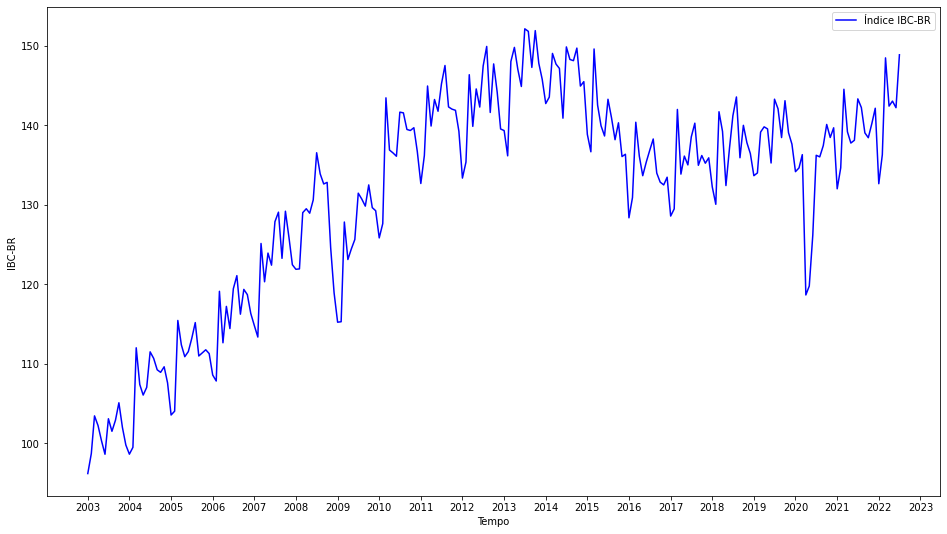

In [107]:
fig = plt.figure(figsize=(16,9))
plt.plot(df['valor'], 'b')
plt.legend(['Índice IBC-BR'])
plt.ylabel('IBC-BR')
plt.xlabel('Tempo')

# ajustamos o eixo x da figura para exibir ticks a cada ano
configurar_ticks_anuais(fig.axes[0])

plt.show()

Pelo gráfico:
- Tendência: observamos que a tendência varia ao longo do tempo (não é linear), mas que a amplitude de variação não parece aumentar ao longo do tempo.
- Sazonalidade: os dados parecem ter uma sazonalidade anual.

In [108]:
from pandas.core.arrays import period
# decompomos os dados usando um modelo aditivo, pois não observamos variações na
# amplitude da curva ao longo do tempo. O período selecionado é de 12 meses, 
# pois temos registros mensais e, aparentemente, uma sazonalidade anual.
decomposed_series = seasonal_decompose(df, model="additive", period=12)

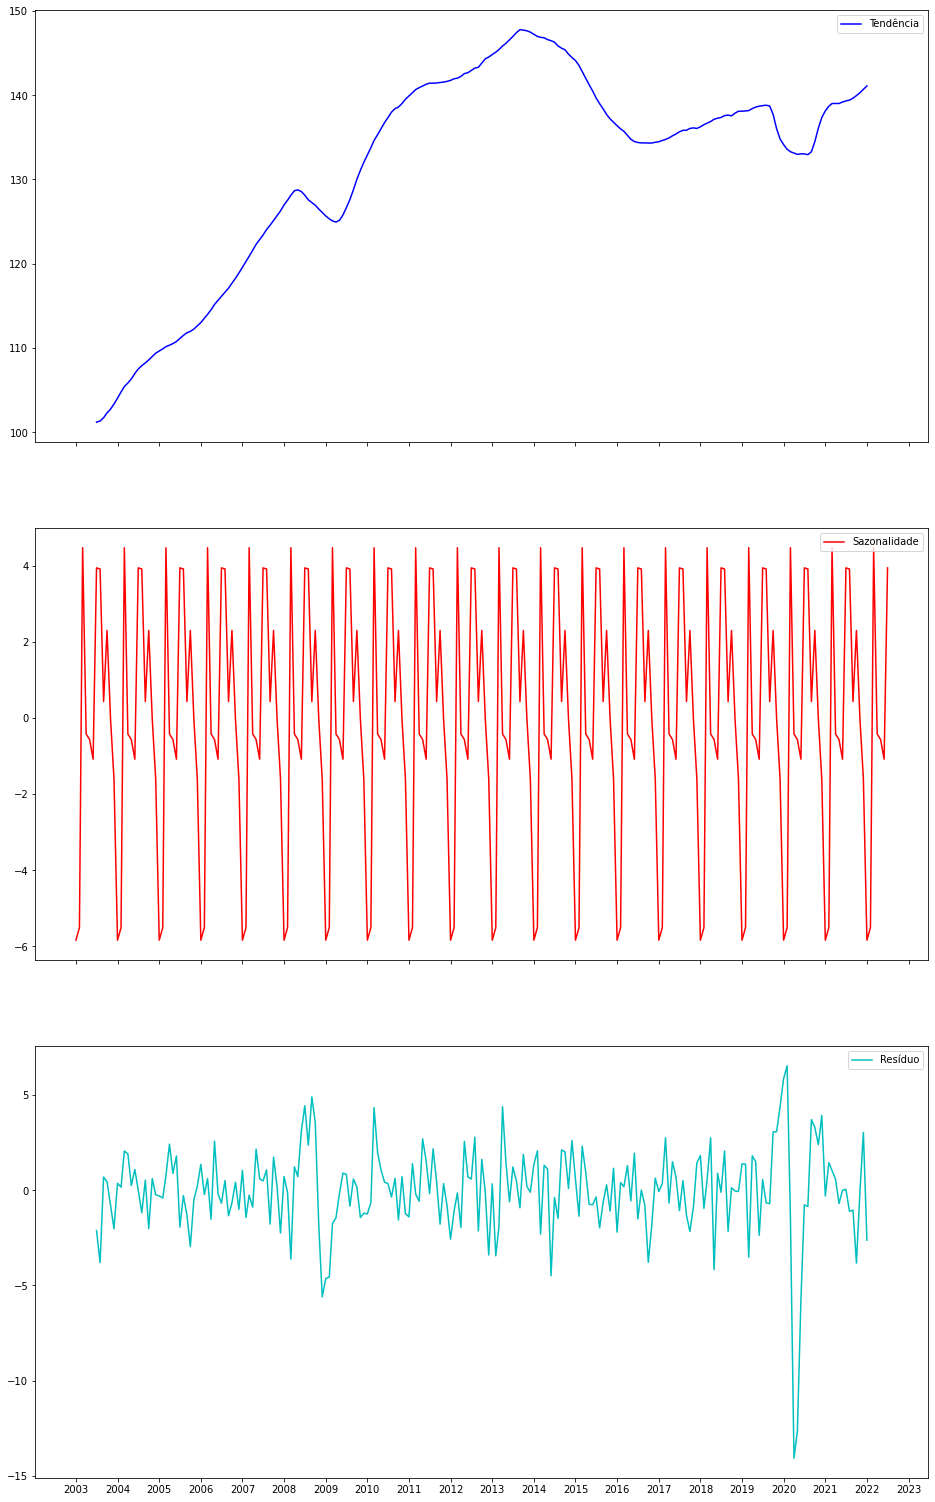

In [109]:
fig, axes = plt.subplots(3, 1, sharex=True)
fig.set_figwidth(16)
fig.set_figheight(9 * 3)

axes[0].plot(decomposed_series.trend, 'b', label='Tendência')
axes[0].legend()

axes[1].plot(decomposed_series.seasonal, 'r', label='Sazonalidade')
axes[1].legend()

axes[2].plot(decomposed_series.resid, 'c', label='Resíduo')
axes[2].legend()

# ajustamos o eixo x da figura para exibir ticks a cada ano
# só precisamos fazer o ajuste para um dos eixos, pois o eixo
# x é compartilhado.
configurar_ticks_anuais(axes[0])

fig.show()

Observamos nos dados que a sazonalidade é bem definida e parece que podemos analisar os componentes de tendência e residual em busca de anomalias.

### Analise das propriedades estatísticas da série temporal

Precisamos entender as propriedades estatísticas de nossa série temporal ao longo do tempo, como a média e a variância, para verificar se podemos aplicar certos métodos estatísticos nos dados.

In [110]:
green = sns.color_palette("deep",8)[2]
blue = sns.color_palette("deep",8)[0]

# FIXME: calcular e verificar as propriedades estatísticas aqui.

### Análise da média móvel

Calculamos a média móvel, com o período da sazonalidade aparente (12 meses), para entender como ela se relaciona com os dados.

In [111]:
# calculamos a média móvel de 12 registros consecutivos
# para obter a média móvel de 12 meses
df_moving_average = df.rolling(window=12).sum() / 12

In [112]:
# ignoramos os 12 primeiros valores da média móvel,
# pois não levam em consideração uma janela completa.
df_moving_average = df_moving_average[13:]

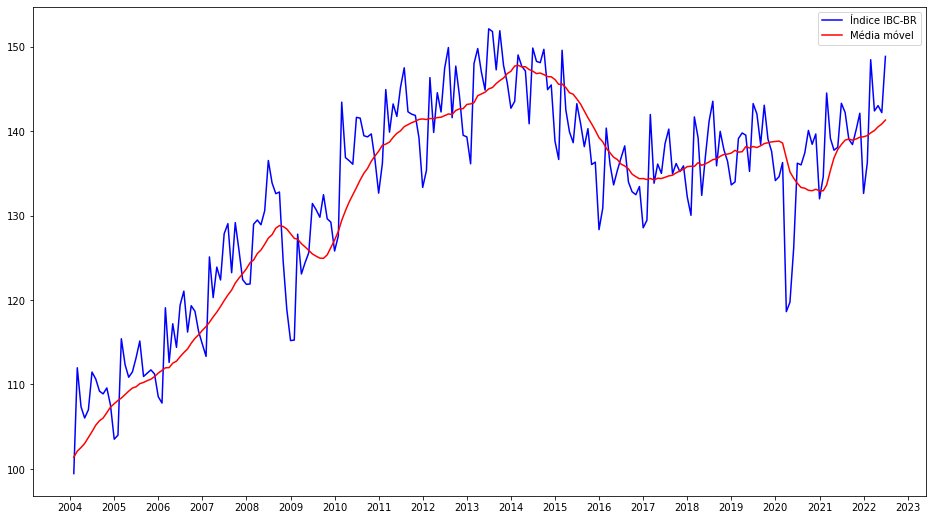

In [113]:
# visualizamos os dados e a média móvel em conjunto,
# aplicando um offset de 12 meses nos dados, pois
# não temos valores da média móvel para os primeiros
# 12 registros dos dados.
fig = plt.figure(figsize=(16,9))

plt.plot(df['valor'][13:], 'b', label='Índice IBC-BR')
plt.plot(df_moving_average, 'r', label='Média móvel')

configurar_ticks_anuais(fig.axes[0])

plt.legend()
plt.show()

In [127]:
#for window in df.rolling(window=12, min_periods=12):
#  print(window)

### Análise da autocorrelação dos dados

In [132]:
def visualizar_autocorrelacao(dados, maxlags):
  fig = plt.figure(figsize=(16,4))
  plt.title('Autocorrelação da série IBC-BR')
  plt.xlabel('Lag da correlação (meses)')
  plt.acorr(dados,maxlags=maxlags)
  plt.grid(True)
  plt.show()

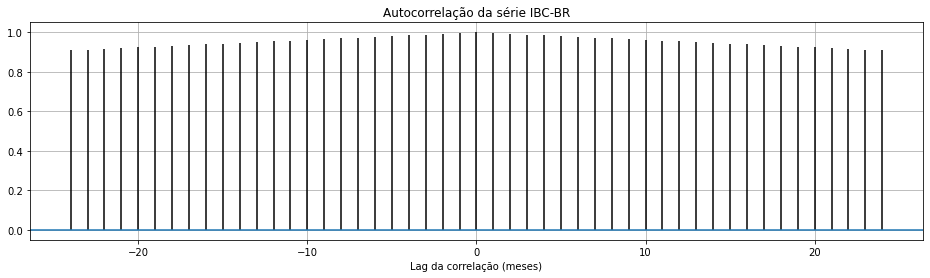

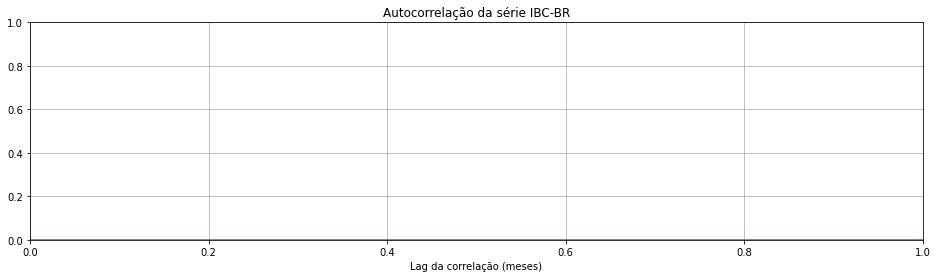

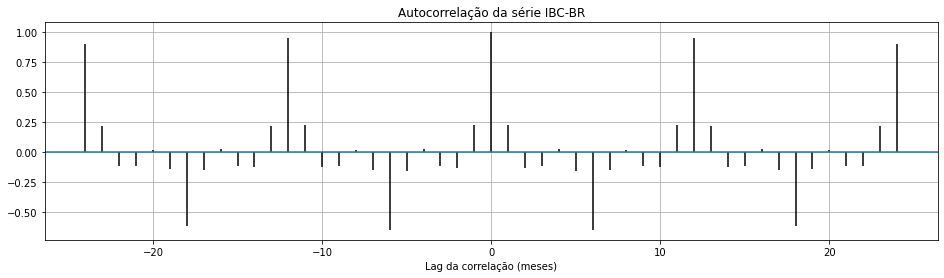

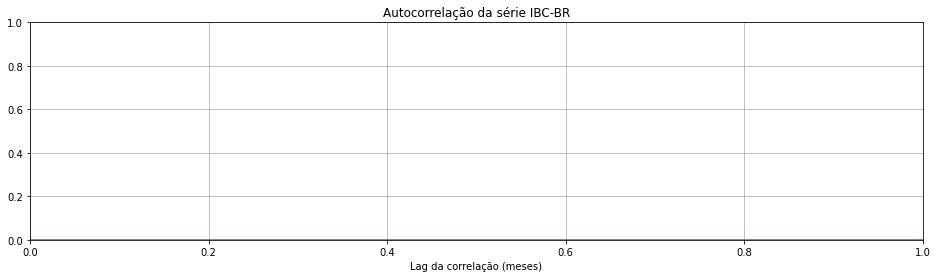

In [135]:
visualizar_autocorrelacao(df['valor'], maxlags=24)
visualizar_autocorrelacao(decomposed_series.trend, maxlags=24)
visualizar_autocorrelacao(decomposed_series.seasonal, maxlags=24)
visualizar_autocorrelacao(decomposed_series.resid, maxlags=24)

## Análise de modelos preditivos para detecção de anomalias nos dados

### SARIMA

A sazonalidade identificada nos dados sugere que um método estatístico preditivo, que leve a sazonalidade em consideração, possa ser útil para detectar anomalias. A ideia é modelar nossa série temporal, prever dados e comparar a predição com a medição. Um dado anômalo nesse contexto seria uma medição que desviasse significativamente da predição.